<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/DIABETES_PREDICTION_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Importing Libraries</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imbalanced-learn
!pip install ydata_profiling


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.7/395.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=d80e5f4e147bbfda0d7d5c34d28755a66cba95bcbc226f3e5e639636ba974eb8
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.layers import Input, LSTM, Dropout, Dense
from keras.models import Model

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Load The Dataset</p>

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset1.csv')

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Exploratory Data Analysis(EDA)</p>

In [ ]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'HbA1c_level', 'blood_glucose_level', 'Outcome'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  100000 non-null  float64
 1   hypertension         100000 non-null  int64  
 2   heart_disease        100000 non-null  int64  
 3   smoking_history      100000 non-null  int64  
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   Outcome              100000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 6.1 MB


In [ ]:
df.describe()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,Outcome
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,0.544560,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,0.498013,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,1.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
df.isnull().sum()

,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
Outcome,0


In [ ]:
print(df.columns)

Index(['age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'HbA1c_level', 'blood_glucose_level', 'Outcome'],
      dtype='object')


In [ ]:
df['Outcome'].value_counts()

,count
Outcome,
0,91500
1,8500


<Axes: xlabel='Outcome', ylabel='count'>

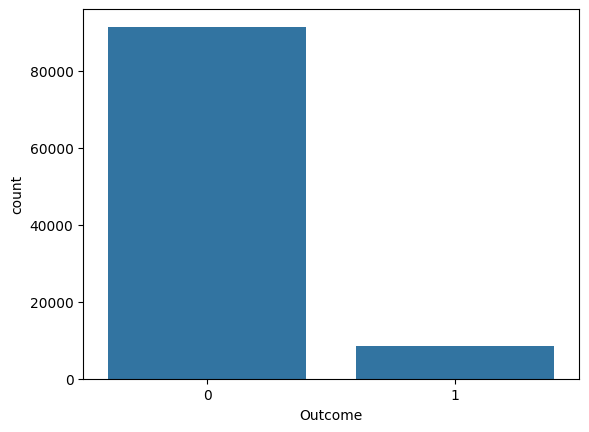

In [ ]:
sns.countplot(x = df['Outcome'])

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Pandas Profiling</p>

In [ ]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Correlation Analysis</p>

Correlations with Outcome:
blood_glucose_level    0.419558
HbA1c_level            0.400660
age                    0.258008
bmi                    0.214357
hypertension           0.197823
heart_disease          0.171727
smoking_history        0.045848
Name: Outcome, dtype: float64


<ipython-input-13-e76549f2922b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_correlations.index, y=sorted_correlations.values, palette='coolwarm')


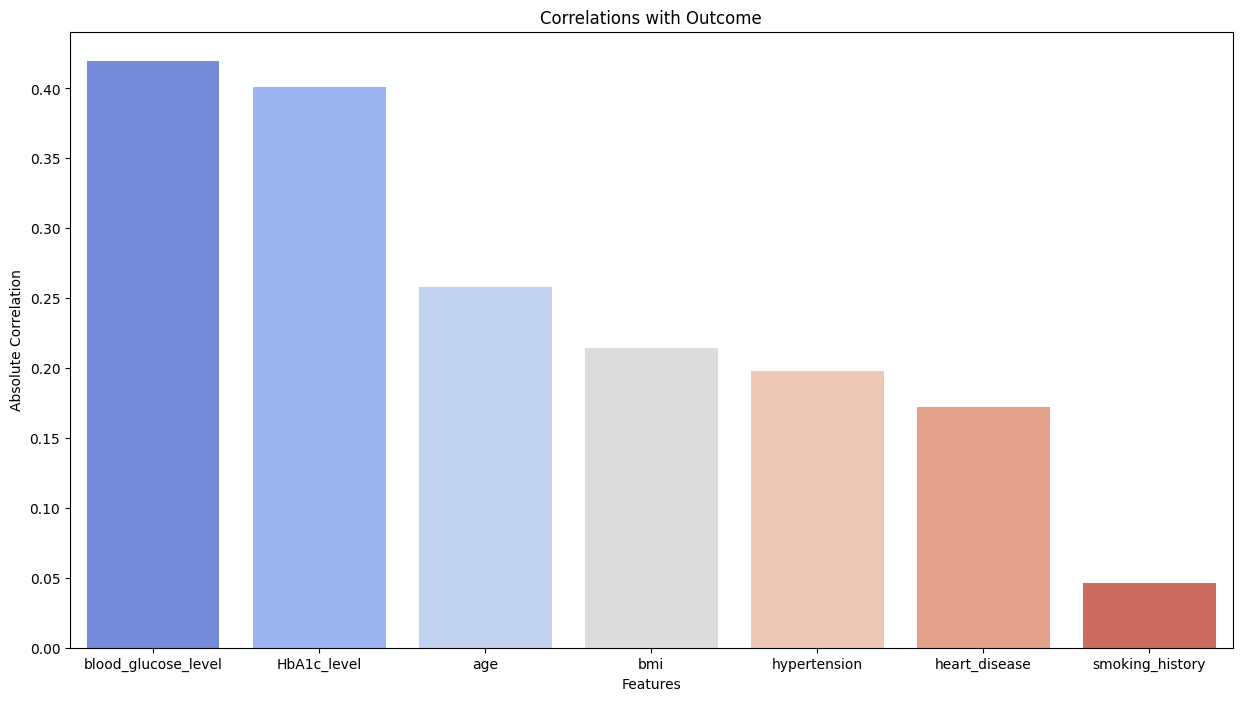

In [ ]:
# Select only numeric features for correlation analysis
numeric_features = df.select_dtypes(include=np.number)

# Calculate the correlation matrix for numeric features
correlation_matrix = numeric_features.corr()

# Continue with the rest of your code
outcome_correlations = correlation_matrix['Outcome'].drop('Outcome')  # Drop the Outcome column itself
sorted_correlations = outcome_correlations.abs().sort_values(ascending=False)
print("Correlations with Outcome:")
print(sorted_correlations)

plt.figure(figsize=(15, 8))
sns.barplot(x=sorted_correlations.index, y=sorted_correlations.values, palette='coolwarm')
plt.title('Correlations with Outcome')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.show()

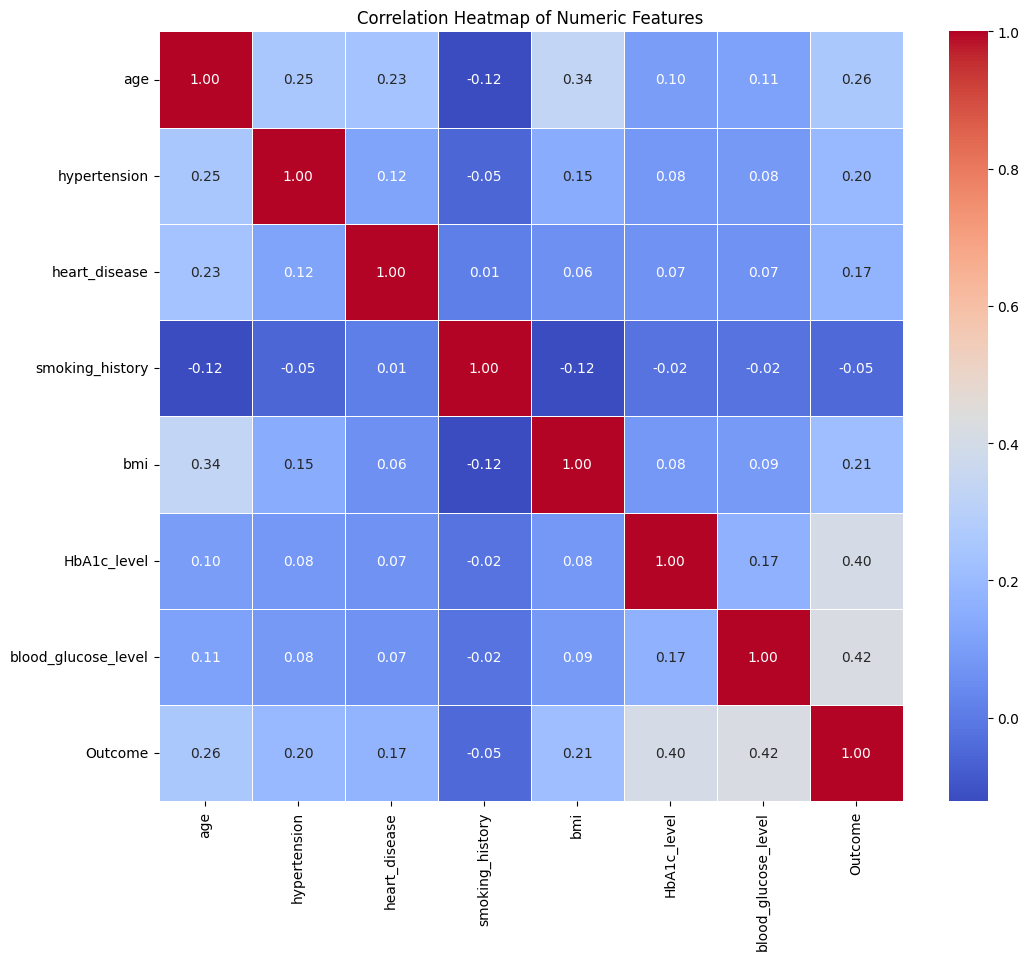

In [ ]:


# Select only numeric features for correlation analysis
numeric_features = df.select_dtypes(include=np.number)

# Calculate the correlation matrix for numeric features
correlation_matrix = numeric_features.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Train-Test-Split</p>

In [ ]:
features = df.drop('Outcome', axis=1)
labels = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Feature Standardization</p>

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">LSTM</p>

In [ ]:
from keras.regularizers import l2
from tensorflow import keras
from keras.layers import Input, LSTM, Dropout, Dense
from keras.models import Model, Sequential # Import Sequential here

X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))  # Add dropout with a rate of 0.2
lstm_model.add(Dense(25, activation='relu'))  # Add an extra dense layer
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=2) # Increased epochs, changed batch size
lstm_pred_proba = lstm_model.predict(X_test_lstm)
lstm_pred = [1 if x > 0.5 else 0 for x in lstm_pred_proba]
lstm_accuracy = accuracy_score(y_test, lstm_pred)
print(f"LSTM Accuracy: {lstm_accuracy:.2f}")

lstm_conf_matrix = confusion_matrix(y_test, lstm_pred)
lstm_classification_report = classification_report(y_test, lstm_pred)

print("\nLSTM Confusion Matrix:")
print(lstm_conf_matrix)
print("\nLSTM Classification Report:")
print(lstm_classification_report)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2500/2500 - 12s - 5ms/step - accuracy: 0.9295 - loss: 0.1968
Epoch 2/50
2500/2500 - 21s - 8ms/step - accuracy: 0.9435 - loss: 0.1526
Epoch 3/50
2500/2500 - 17s - 7ms/step - accuracy: 0.9482 - loss: 0.1401
Epoch 4/50
2500/2500 - 11s - 4ms/step - accuracy: 0.9506 - loss: 0.1345
Epoch 5/50
2500/2500 - 10s - 4ms/step - accuracy: 0.9530 - loss: 0.1304
Epoch 6/50
2500/2500 - 10s - 4ms/step - accuracy: 0.9543 - loss: 0.1261
Epoch 7/50
2500/2500 - 10s - 4ms/step - accuracy: 0.9556 - loss: 0.1247
Epoch 8/50
2500/2500 - 11s - 5ms/step - accuracy: 0.9557 - loss: 0.1234
Epoch 9/50
2500/2500 - 10s - 4ms/step - accuracy: 0.9567 - loss: 0.1221
Epoch 10/50
2500/2500 - 10s - 4ms/step - accuracy: 0.9565 - loss: 0.1217
Epoch 11/50
2500/2500 - 9s - 4ms/step - accuracy: 0.9573 - loss: 0.1202
Epoch 12/50
2500/2500 - 10s - 4ms/step - accuracy: 0.9580 - loss: 0.1185
Epoch 13/50
2500/2500 - 10s - 4ms/step - accuracy: 0.9578 - loss: 0.1189
Epoch 14/50
2500/2500 - 9s - 4ms/step - accuracy: 0.9577 - lo

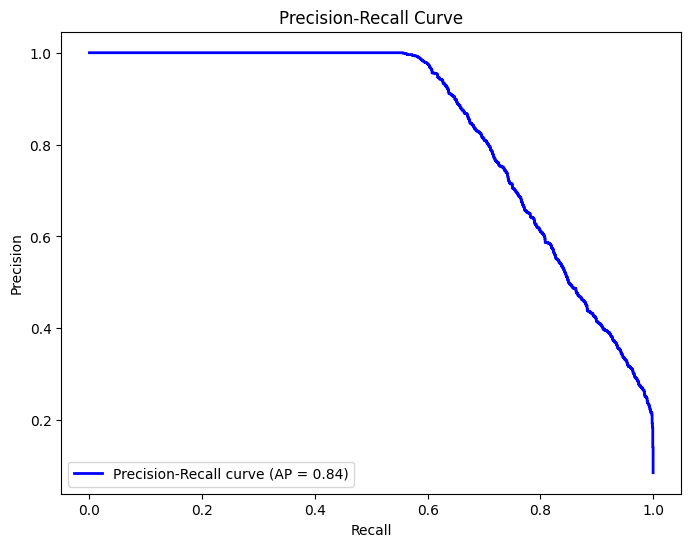

In [ ]:

# Calculate precision-recall curve and average precision
precision, recall, thresholds = precision_recall_curve(y_test, lstm_pred_proba)
average_precision = average_precision_score(y_test, lstm_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


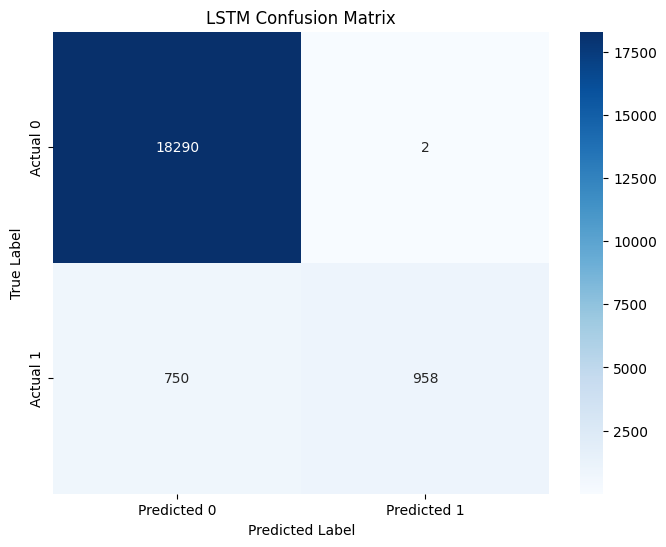

In [ ]:
# After fitting the LSTM model and making predictions:
lstm_pred_proba = lstm_model.predict(X_test_lstm)
lstm_pred = [1 if x > 0.5 else 0 for x in lstm_pred_proba]

# Calculate the confusion matrix
lstm_conf_matrix = confusion_matrix(y_test, lstm_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


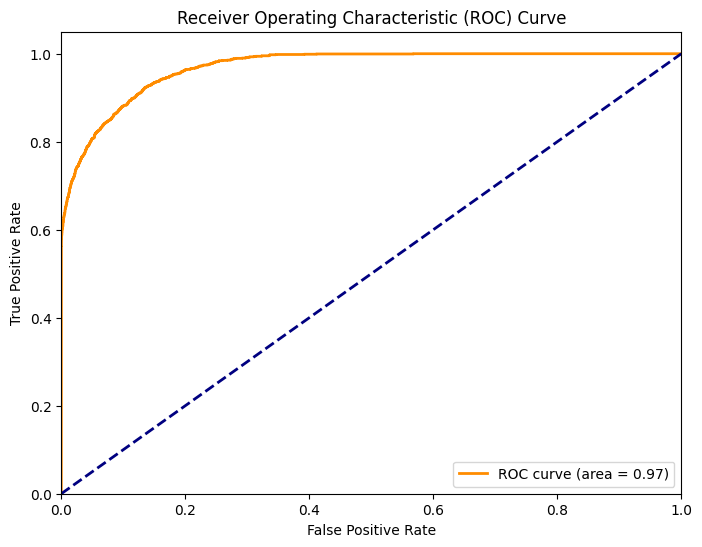

In [ ]:
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities for the positive class
lstm_pred_proba = lstm_model.predict(X_test_lstm)[:, 0]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, lstm_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


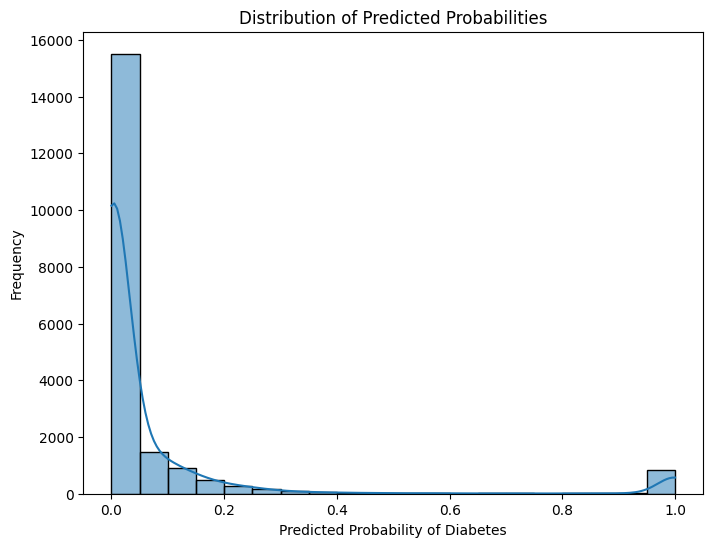

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities for the positive class
lstm_pred_proba = lstm_model.predict(X_test_lstm)[:, 0]

# Plot the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
sns.histplot(lstm_pred_proba, bins=20, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Diabetes')
plt.ylabel('Frequency')
plt.show()